#Clustering: GMM algorithm

##Librerías

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score, silhouette_samples, davies_bouldin_score, adjusted_rand_score
from collections import Counter
from sklearn.metrics import pairwise_distances

##Datos

###Obtener datos de csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar el archivo clases.txt
clases = pd.read_csv('/content/drive/MyDrive/IA/clase.txt', delimiter=',')

# Cargar el archivo datasettissue.txt
data = pd.read_csv('/content/drive/MyDrive/IA/dataset_tissue.txt', delimiter=',')
data = data.T
data = pd.DataFrame(data)

Mounted at /content/drive


###Normalizar datos

In [ ]:
# Eliminar la columna 'Unnamed: 0' del DataFrame
temp_data = data.drop(['Unnamed: 0'], axis=0)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(temp_data)

###Reducir features

In [ ]:
# Aplicar PCA para reducción de dimensionalidad
#PCA
pca = PCA()
pca.fit(normalized_data)
pca_data = pca.transform(normalized_data)

data_reduced = pd.DataFrame(pca_data[:,0:75])
data_reduced = data_reduced.values

##GMM from scratch


In [ ]:
#Calcular la altura de cada punto
def probabilidad_punto(mean, covariance, punto):
  coeficiente = np.exp(-1/2 * np.dot(np.dot((punto - mean).T, np.linalg.inv(covariance)), punto - mean))
  div = 1 / ((2 * np.pi) ** (len(punto)/2)* np.sqrt(np.linalg.det(covariance)))
  return coeficiente * div

###Paso 1
Inicializar la media, covarianza y probabilidad de cada campana

In [ ]:
def init(data, n_clusters):
  np.random.seed(0)
  N, features = data.shape

  cluster_probabilities = np.ones(n_clusters) / n_clusters
  means = data[np.random.choice(N, n_clusters, replace=False)]
  covariances = [np.cov(data, rowvar=False)] * n_clusters

  return cluster_probabilities, means, covariances

###Paso 2: E step
Calculos de las probabilidades aposteriori usando los parámetros actuales


In [ ]:
def e_step(data, means, covariances, pi_s):
  N, features = data.shape
  nro_clusters = len(pi_s)
  P_posteriori = np.zeros((len(data), nro_clusters))

  for k in range(nro_clusters):
    for n in range(N):
      P_posteriori[n][k] = pi_s[k] * probabilidad_punto(means[k],covariances[k], data[n])
      if np.isnan(P_posteriori[n,:]).any():
                  P_posteriori[n,:] = 1/nro_clusters

  total_probabilities = np.sum(P_posteriori, axis=1, keepdims=True)
  P_posteriori /= total_probabilities
  return P_posteriori



###Paso 3: M step
Re calcular los parametros dadas las probabilidades aposteriori

In [ ]:
def m_step(data,P_posteriori, nro_clusters):

  N, n_features = data.shape
  Nk = np.sum(P_posteriori, axis=0)

  #Nuevos valores de probabilidad
  N_Pcluster = Nk / N

  #Nuevos valores para la media
  new_means = []
  for k in range(nro_clusters):
      uk = []
      for n in range(n_features):
          ukn = np.dot(data[:, n], P_posteriori[:, k])
          uk.append(ukn/Nk[k])
      new_means.append(uk)

  #Nuevos valores para la covarianza
  new_covariances = np.zeros((nro_clusters, n_features, n_features))

  for i in range(nro_clusters):
      diff = data - new_means[i]
      new_covariances[i] = np.dot((P_posteriori[:, i][:, np.newaxis] * diff).T, diff) / Nk[i]

  return N_Pcluster, new_means, new_covariances

###Algoritmo

In [ ]:
#Algoritmo de GMM
def GMM(data, n_clusters, epochs=100, tolerance=1e-4):
    cluster_probabilities, means, covariances = init(data, n_clusters)
    prev_likelihood = 0

    for i in range(epochs):
        posterior_probabilities = e_step(data, means, covariances, cluster_probabilities)
        cluster_probabilities, means, covariances = m_step(data, posterior_probabilities, n_clusters)
        likelihood = np.sum(np.log(np.sum(posterior_probabilities, axis=1)))

        if abs(likelihood - prev_likelihood) < tolerance:
            break

        prev_likelihood = likelihood

    return np.argmax(posterior_probabilities, axis=1)



##Experimentación

In [ ]:
#Definir cantidad de clusters (campanas)
nro_clusters = len(set(clases['x']))
print("Cantidad de clusters posibles:", nro_clusters)

clusters = GMM(data_reduced, nro_clusters)
print("Clusters:", clusters)

# Imprimir nombres de tejidos en cada cluster
for i in range(nro_clusters):
    cluster_indices = np.where(clusters == i)[0]
    tejidos_cluster = clases.iloc[cluster_indices]['x']
    print(f'Cluster {i}: {", ".join(tejidos_cluster)}')


Cantidad de clusters posibles: 7
Clusters: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 0 5 5
 3 5 5 5 5 5 5 5 5 5 5 5 4 4 4 5 5 5 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5]
Cluster 0: colon
Cluster 1: kidney
Cluster 2: endometrium, endometrium, endometrium
Cluster 3: colon, colon
Cluster 4: liver, liver, liver, liver, liver
Cluster 5: kidney, kidney, kidney, kidney, kidney, kidney, kidney, kidney, kidney, kidney, kidney, kidney, kidney, kidney, kidney, kidney, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippoca

In [ ]:
def calculate_silhouette_coefficient(data, clusters):
    n_samples = len(data)
    silhouette_vals = np.zeros(n_samples)

    for i in range(n_samples):
        # Calcula a(i) (promedio de la distancia a otras muestras en el mismo cluster)
        cluster_idx = clusters[i]
        cluster_data = data[clusters == cluster_idx]
        a_i = np.mean(pairwise_distances(data[i].reshape(1, -1), cluster_data))

        # Calcula b(i) (promedio de la distancia a las muestras en el cluster más cercano diferente al de la muestra)
        b_i = np.min([np.mean(pairwise_distances(data[i].reshape(1, -1), data[clusters == other_cluster_idx]))
                      for other_cluster_idx in range(len(np.unique(clusters))) if other_cluster_idx != cluster_idx])

        # Calcula coeficiente de silueta para la muestra i
        silhouette_vals[i] = (b_i - a_i) / max(a_i, b_i)

    # Calcula la silueta promedio
    avg_silhouette = np.mean(silhouette_vals)
    return avg_silhouette

# Uso de la función (data son tus datos, clusters son las etiquetas de los clusters)
silueta_p = calculate_silhouette_coefficient(normalized_data, clusters)

# Luego puedes imprimir la silueta promedio del clustering
print(f'Silueta promedio del clustering: {silueta_p}')

Silueta promedio del clustering: -0.03428813222635563


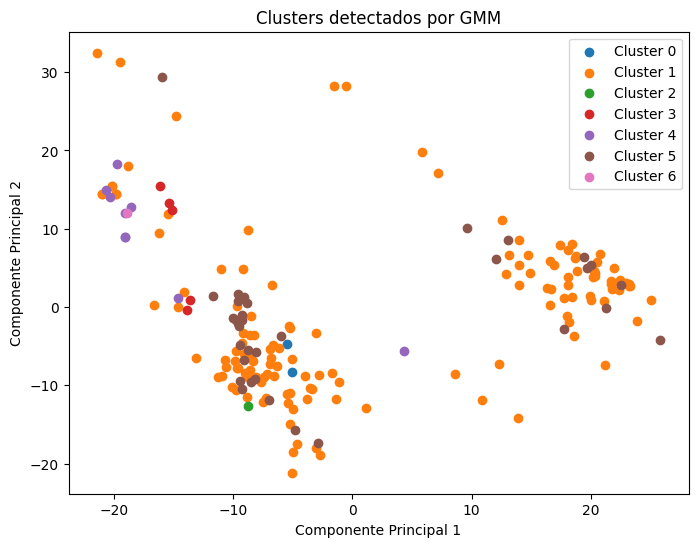

Shape de data: (190, 22215)
Shape de clases: (189, 2)
Shape de clusters: (189,)
Cluster 0: kidney, kidney
Cluster 1: kidney, kidney, kidney, kidney, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, hippocampus, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, cerebellum, kidney, kidney, kidney, kidney, kidney, kidney, kidney, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon, colon,

In [ ]:
# Visualizar los clusters en un gráfico 2D
plt.figure(figsize=(8, 6))
n_components = 7

for i in range(n_components):
    cluster_data = pca_data[clusters == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters detectados por GMM')
plt.legend()
plt.show()

print("Shape de data:", data.shape)
print("Shape de clases:", clases.shape)
print("Shape de clusters:", clusters.shape)

# Imprime nombres de tejidos en cada cluster
for i in range(n_components):
    cluster_indices = np.where(clusters == i)[0]
    tejidos_cluster = clases.iloc[cluster_indices]['x']
    print(f'Cluster {i}: {", ".join(tejidos_cluster)}')

print(clusters)

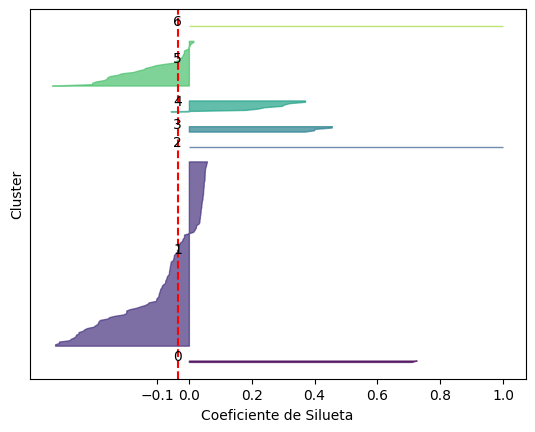

In [ ]:
#Calcular el coeficiente de la silueta para cada muestra en un conjunto de datos y sus respectivas asignaciones a clusters
def calculate_silhouette_coefficient(data, clusters):
    n_samples = len(data)
    silhouette_vals = np.zeros(n_samples)

    for i in range(n_samples):
        # Calcula a(i) (promedio de la distancia a otras muestras en el mismo cluster)
        cluster_idx = clusters[i]
        cluster_data = data[clusters == cluster_idx]
        a_i = np.mean(pairwise_distances(data[i].reshape(1, -1), cluster_data))

        # Calcula b(i) (promedio de la distancia a las muestras en el cluster más cercano diferente al de la muestra)
        b_i = np.min([np.mean(pairwise_distances(data[i].reshape(1, -1), data[clusters == other_cluster_idx]))
                      for other_cluster_idx in range(len(np.unique(clusters))) if other_cluster_idx != cluster_idx])

        # Calcula coeficiente de silueta para la muestra i
        silhouette_vals[i] = (b_i - a_i) / max(a_i, b_i)

    # Calcula la silueta promedio
    avg_silhouette = np.mean(silhouette_vals)
    return silhouette_vals, avg_silhouette

#Graficar el coeficiente de la silueta de cada muestra
def plot_silhouette_graph(data, clusters):
    silhouette_vals, avg_silhouette = calculate_silhouette_coefficient(data, clusters)
    cluster_labels = np.unique(clusters)
    n_clusters = len(cluster_labels)

    y_lower = 10
    fig, ax = plt.subplots()
    for i in range(n_clusters):
        ith_cluster_silhouette_vals = silhouette_vals[clusters == cluster_labels[i]]
        ith_cluster_silhouette_vals.sort()
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.viridis(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    silhouette_avg = np.mean(silhouette_vals)
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xlabel("Coeficiente de Silueta")
    ax.set_ylabel("Cluster")

    plt.show()

# Uso de la función (normalized_data son tus datos normalizados, clusters son las etiquetas de los clusters)
plot_silhouette_graph(normalized_data, clusters)


In [ ]:
# Calcular y visualizar las métricas de calidad del clustering
homogeneity = homogeneity_score(clases['x'], clusters)
completeness = completeness_score(clases['x'], clusters)
v_measure = v_measure_score(clases['x'], clusters)

#Métricas de calidad de Clustering
print("Métricas de Calidad del Clustering:")

# Métrica de homogeneidad
print(f'Homogeneidad del Clustering: {homogeneity:.2f}')

# Métrica de Completitud
print(f'Completitud del Clustering: {completeness:.2f}')

# Métrica de Puntuación
print(f'Puntuación V-measure: {v_measure:.2f}')

Homogeneidad del Clustering: 0.14
Completitud del Clustering: 0.29
Puntuación V-measure: 0.19


In [ ]:
# Contar las ocurrencias de cada tejido en cada cluster
tejidos_por_cluster = {}
for cluster_idx in set(clusters):
    indices_cluster = np.where(clusters == cluster_idx)[0]
    tejidos_cluster = list(clases.iloc[indices_cluster]['x'])
    counter = Counter(tejidos_cluster)
    tejidos_por_cluster[cluster_idx] = counter

# Visualizar los tejidos más frecuentes en cada cluster
for cluster_idx, tejidos_counter in tejidos_por_cluster.items():
    print(f'Cluster {cluster_idx}:')
    for tejido, count in tejidos_counter.most_common():
        print(f'  - {tejido}: {count} veces')


Cluster 0:
  - kidney: 2 veces
Cluster 1:
  - cerebellum: 31 veces
  - colon: 28 veces
  - hippocampus: 27 veces
  - kidney: 19 veces
  - endometrium: 15 veces
  - liver: 12 veces
  - placenta: 5 veces
Cluster 2:
  - kidney: 1 veces
Cluster 3:
  - liver: 5 veces
Cluster 4:
  - liver: 8 veces
  - cerebellum: 1 veces
Cluster 5:
  - kidney: 17 veces
  - cerebellum: 6 veces
  - colon: 6 veces
  - hippocampus: 4 veces
  - placenta: 1 veces
Cluster 6:
  - liver: 1 veces


Cluster 0: Tejido más común - kidney
Cluster 1: Tejido más común - cerebellum
Cluster 2: Tejido más común - kidney
Cluster 3: Tejido más común - liver
Cluster 4: Tejido más común - liver
Cluster 5: Tejido más común - kidney
Cluster 6: Tejido más común - liver


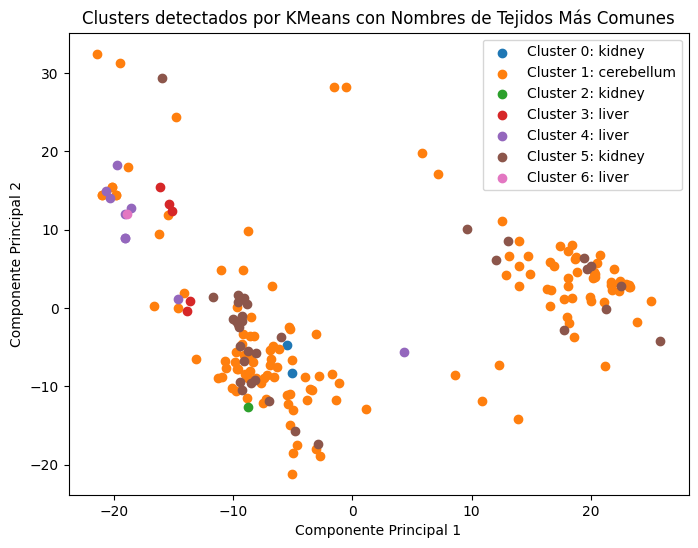

In [ ]:
# Obtener el nombre del tejido más frecuente en cada cluster
cluster_names = []
for i in range(nro_clusters):
    cluster_indices = np.where(clusters == i)[0]
    tejidos_cluster = clases.iloc[cluster_indices]['x']
    most_common_tejido = tejidos_cluster.value_counts().idxmax()
    cluster_names.append(most_common_tejido)
    print(f'Cluster {i}: Tejido más común - {most_common_tejido}')

# Visualizar clusters con nombres de tejidos más comunes
plt.figure(figsize=(8, 6))
for i in range(nro_clusters):
    cluster_data = data_reduced[clusters == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}: {cluster_names[i]}')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters detectados por KMeans con Nombres de Tejidos Más Comunes')
plt.legend()
plt.show()
